# **Simulazione di DoNothingAgent**

Questa simulazione viene utilizzata per testare l'agente DoNothingAgent e verificare che non effettui alcun tipo di azione nell'ambiente. Lo scopo principale è di testare le funzionalità dell'ambiente CityLearn.


**Lista degli import**

In [1]:
from agents.DoNothingAgent import DoNothingAgent as Agent
from citylearn.citylearn import CityLearnEnv

#import per strutture dati
import pandas as pd

#import per grafici
from utils import plotting_functions as plt

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


Couldn't import dot_parser, loading of dot files will not be possible.


Questa parte di codice permette di avviare una simulazione utilizzando l'agente da noi sviluppato. In questo caso la simulazione verrà effettuata su tutti gli edifici del distretto ma al termine estrarremmo le informazioni soltanto da un edificio (per semplicità di rappresentazione).
Il flag **central_agent** permette che la lista delle azioni sia un array con tutte le azioni possibili su tutti i building del distretto.
Il flag **truncated**, se vero, avverte che uno step è terminato a causa di un time limit o una motivazione indefinita.

In [14]:
# Inizializza l'ambiente
# citylearn_challenge_2023_phase_2_local_evaluation è una simulazione nel mese di GIUGNO
env = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)

#print("Di seguito vengono mostrate le azioni possibili nell'ambiente") 
#Si ricorda che in questo caso i dispositivi sono solo quelli con possibilità di azione e sono compresi tutti gli edifici
#display(env.unwrapped.action_names)
#print("\n\n\n")

# Inizializza l'agente
model = Agent(env)

# Resetto la simulazione allo step iniziale
observations, _ = env.reset()

# Seleziona un preciso edificio nell'ambiente
num_building = 0
step=0
#obs_data = env.buildings[num_building]._get_observations_data()
#display(obs_data)

while not env.terminated:
    actions = model.predict(observations)

    #Ottengo i dati osservati per un solo edificio
    #obs_data = env.buildings[num_building]._get_observations_data()
    #display(obs_data)
    #display(env.buildings[0].cooling_device.electricity_consumption)
    #Effettua uno step nell simulazione restitudendo i seguendi flag/informazioni
    observations, reward, info, terminated, truncated = env.step(actions)
    
    step+=1

display(env.observation_names)   
#display(env.buildings[num_building].occupant_count)
#display(env.buildings[0].energy_from_cooling_storage)

[['day_type',
  'hour',
  'outdoor_dry_bulb_temperature',
  'outdoor_dry_bulb_temperature_predicted_1',
  'outdoor_dry_bulb_temperature_predicted_2',
  'outdoor_dry_bulb_temperature_predicted_3',
  'diffuse_solar_irradiance',
  'diffuse_solar_irradiance_predicted_1',
  'diffuse_solar_irradiance_predicted_2',
  'diffuse_solar_irradiance_predicted_3',
  'direct_solar_irradiance',
  'direct_solar_irradiance_predicted_1',
  'direct_solar_irradiance_predicted_2',
  'direct_solar_irradiance_predicted_3',
  'carbon_intensity',
  'indoor_dry_bulb_temperature',
  'non_shiftable_load',
  'solar_generation',
  'dhw_storage_soc',
  'electrical_storage_soc',
  'net_electricity_consumption',
  'electricity_pricing',
  'electricity_pricing_predicted_1',
  'electricity_pricing_predicted_2',
  'electricity_pricing_predicted_3',
  'cooling_demand',
  'dhw_demand',
  'occupant_count',
  'power_outage',
  'indoor_dry_bulb_temperature_cooling_set_point',
  'indoor_dry_bulb_temperature',
  'non_shiftable_lo

Di seguito vengono estrappolati i dati di osservazioni complessivi dall'ambiente per effettuarne così una valutazione. Successivamente richiamamo le funzioni di plotting definiti per graficare i risultati

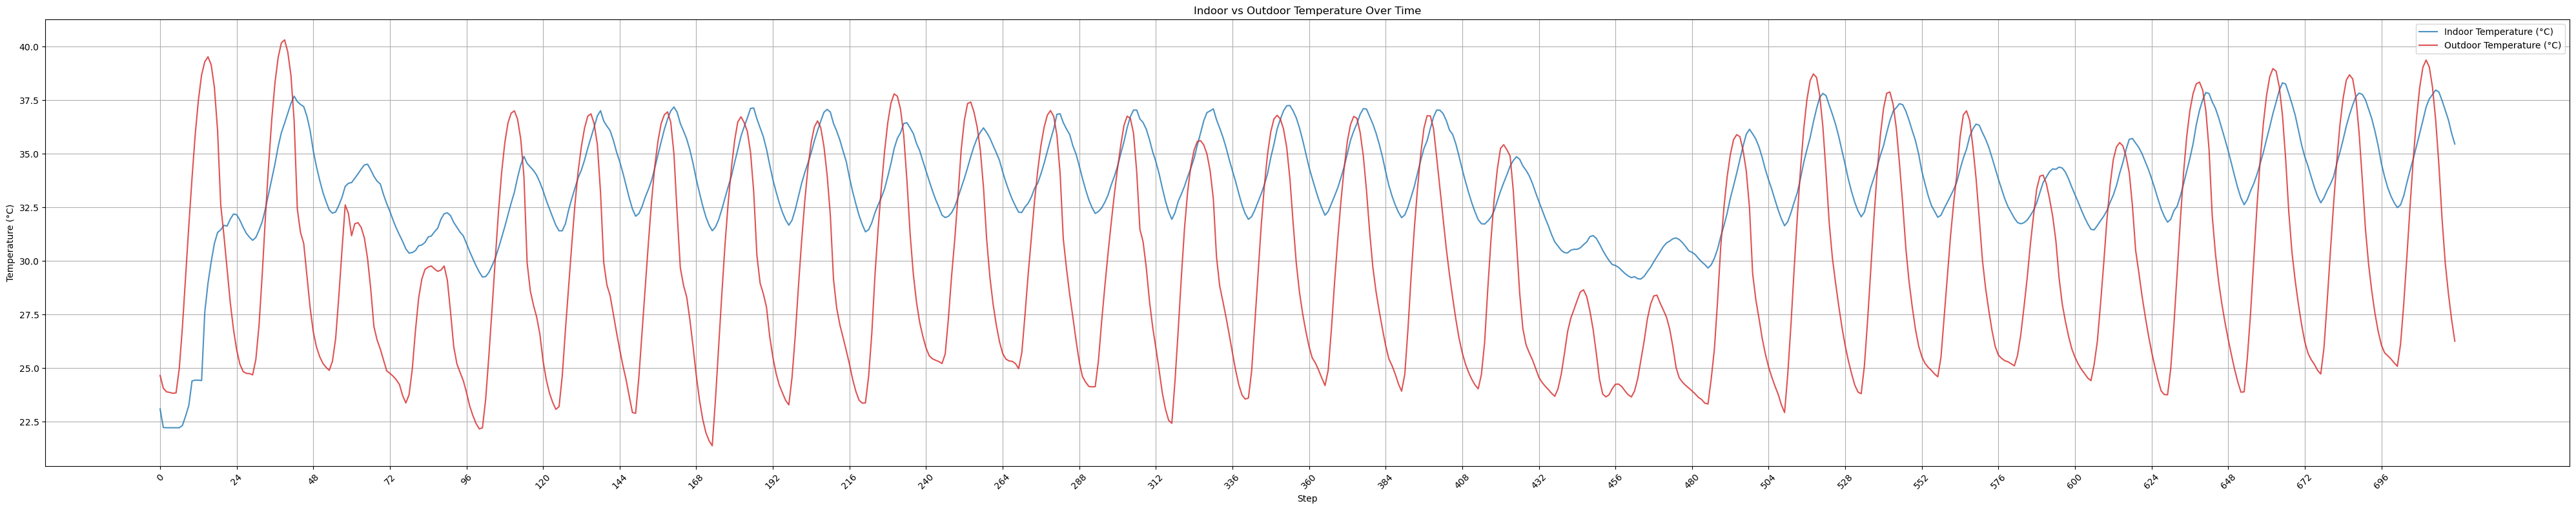

In [3]:
indoor_temp = env.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = env.buildings[num_building].weather.outdoor_dry_bulb_temperature

plt.plot_comparison_two(
    indoor_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature (°C)',
    label2='Outdoor Temperature (°C)'
)


Mostriamo l'energia utilizzata dai dispositivi di riscaldamento/raffredamento per poter visualizzare il lavoro effettuato per regolare la temperatura nelle varie situazioni. I picchi iniziali nel consumo di energia sono dovuti al fatto che l'ambiente parte con una cooling_demand iniziale diversa da 0. Ciò è dovuto al fatto che l'agente inizia ad effettuare azioni/controlli sulla pompa di calore quando sono presenti abbastanza osservazioni nell'ambiente per l'LTSM (gestore della temperatura dinamica), fino ad allora l'ambiente mantiene il carico ideale. Ciò serve per fornire una base di valori a cui poter fare una "lookback" realistica e permettere all'agente di lavorare in ottimalità e in alcuni casi apprendere. A livello pratico, finchè la cooling_demand non raggiunge 0, l'ambiente indipendentemente dalle azioni (in questo caso poste a 0) entra in un circolo vizioso di consumi di potenza (forniti con un carico ideale) che terminano con la terminazione della domanda. Successivamente a ciò entrano in gioco le azioni dell'agente, che non verrano più interrotte negli step successivi.

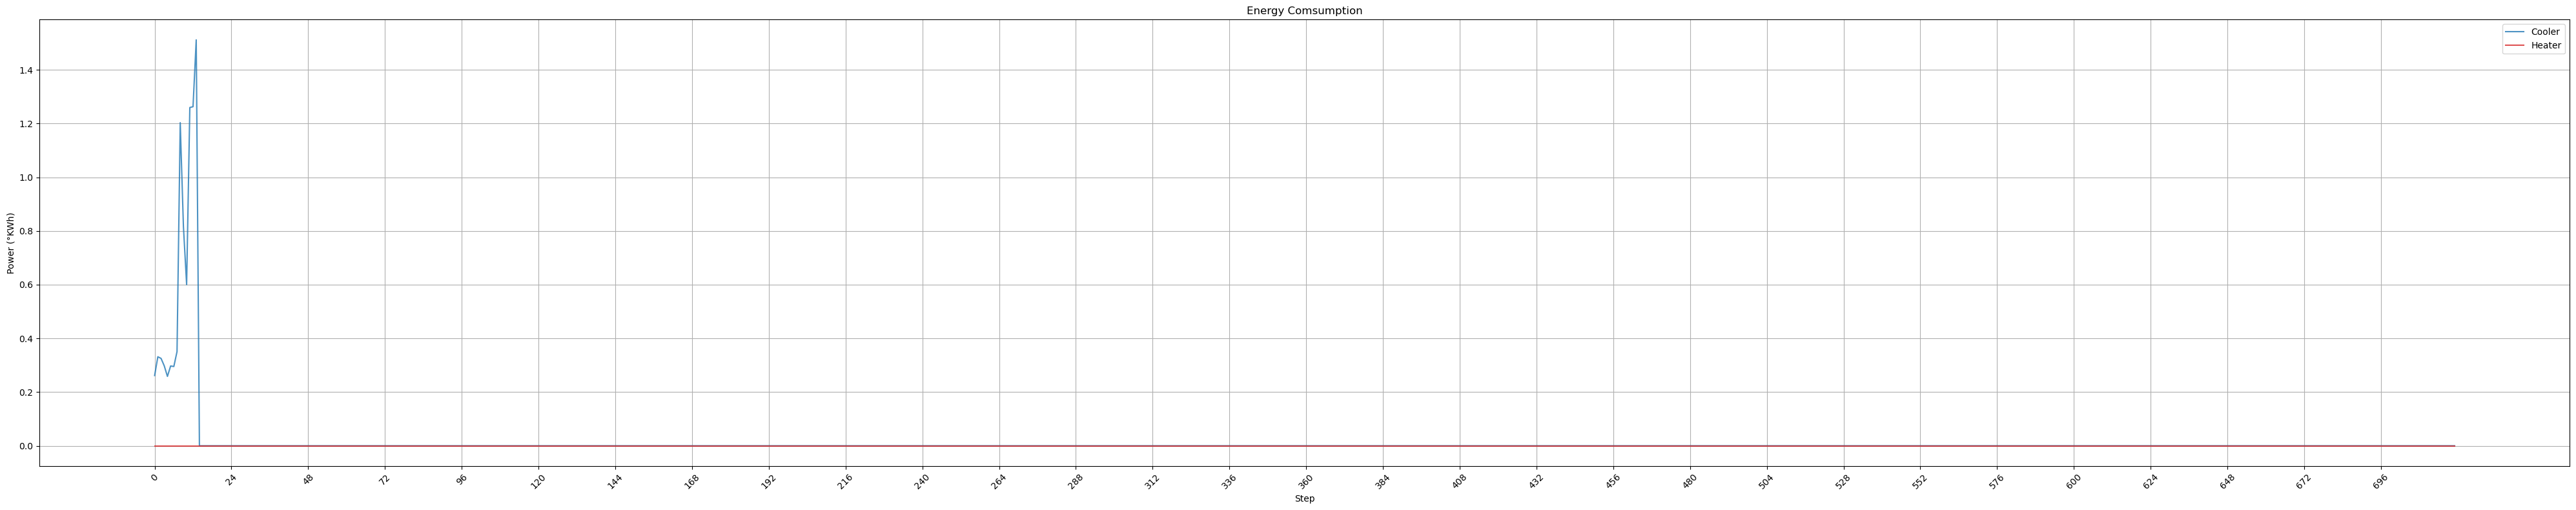

In [4]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy = env.buildings[num_building].cooling_electricity_consumption
heater_energy = env.buildings[num_building].heating_electricity_consumption

plt.plot_comparison_two(
    cooler_energy,
    heater_energy,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label1='Cooler',
    label2='Heater'
)

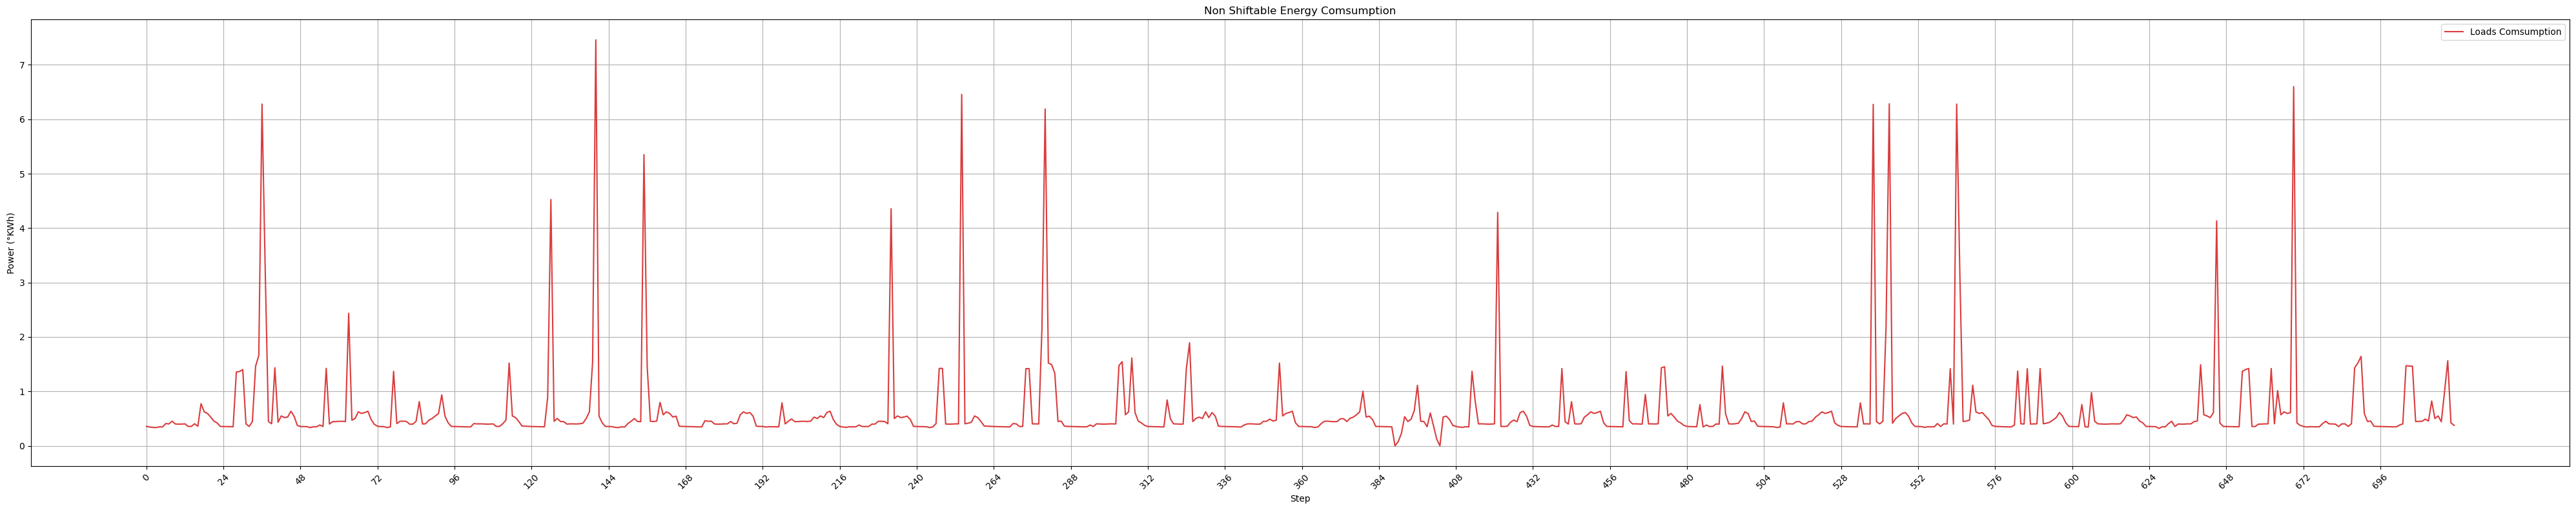

In [5]:

non_energy = env.unwrapped.buildings[num_building].non_shiftable_load_electricity_consumption

plt.plot_single_agent(
    non_energy,
    ylabel='Power (°KWh)',
    title='Non Shiftable Energy Comsumption',
        label='Loads Comsumption',

)

Per completezza vengono aggiunti i consumi generali della casa, che comprendono tutti i dispositivi e accumulatori collegati.

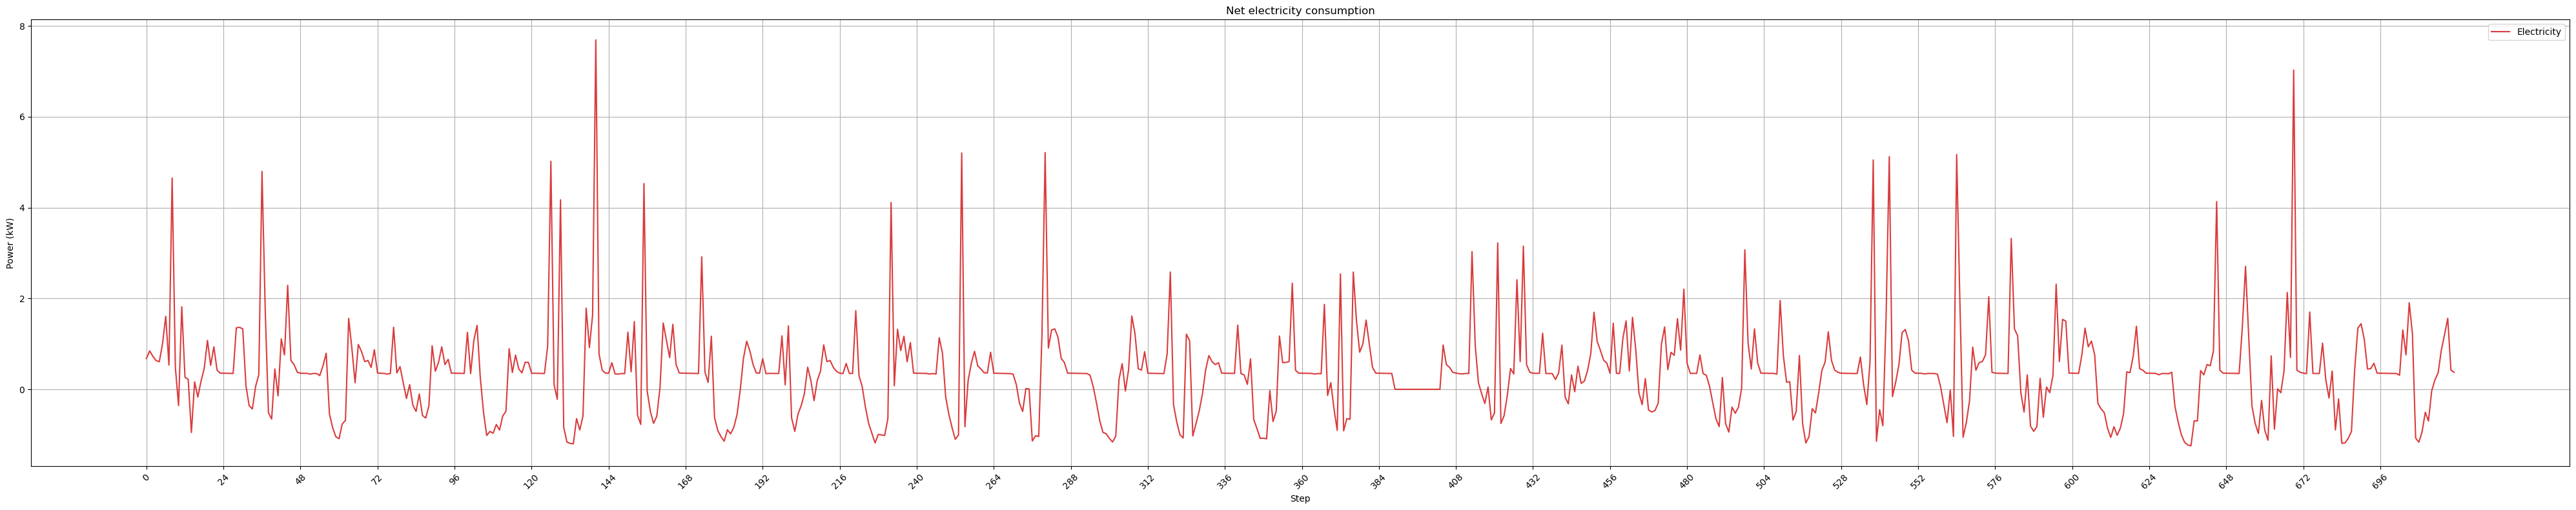

In [6]:
#Calcola il consumo di elettricità totale dell'edificio
net_electricity_consumption_log = env.buildings[num_building].net_electricity_consumption

plt.plot_single_agent(
    net_electricity_consumption_log,
    ylabel='Power (kW)',
    title='Net electricity consumption',
    label='Electricity'
)

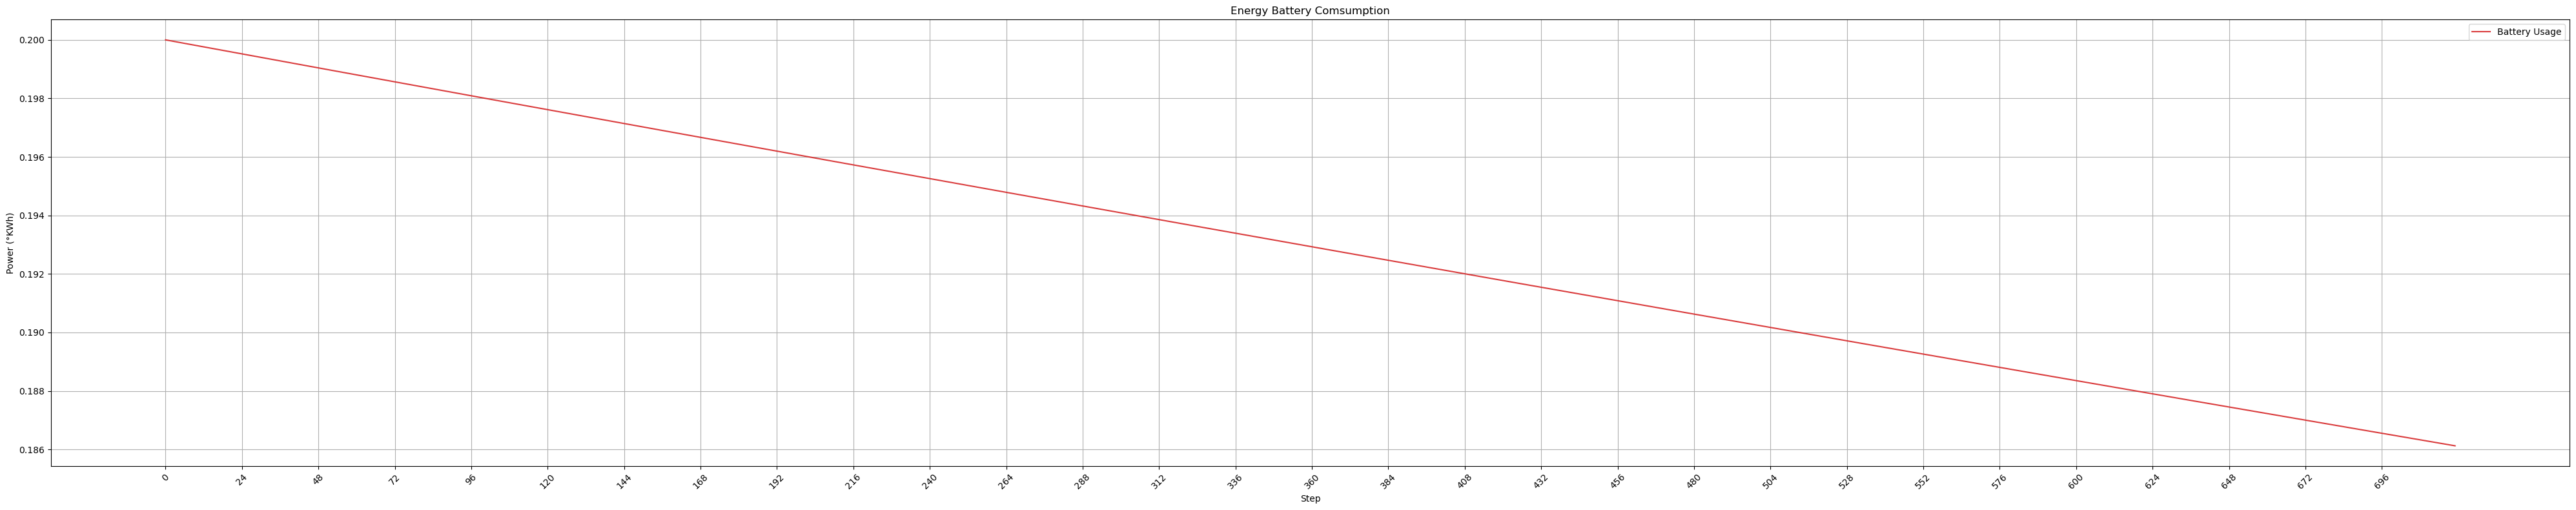

In [7]:
agent_data1 = env.unwrapped.buildings[num_building].electrical_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='Battery Usage'
)

La parte seguente viene fornita direttamente dalla documentazione di CityLearn e effettua una valutazione dell'algoritmo sulle **cost_function**. Alcune di esse sono a NaN in quanto sono esclusivamente valori riguardanti a distretti interi.

In [8]:
kpis = model.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

name,Building_1,Building_2,Building_3,District
cost_function,,,,
all_time_peak_average,NaN,NaN,NaN,0.832
annual_normalized_unserved_energy_total,0.015,0.012,0.014,0.014
carbon_emissions_total,0.378,0.347,0.484,0.403
cost_total,0.357,0.323,0.454,0.378
daily_one_minus_load_factor_average,NaN,NaN,NaN,1.315
daily_peak_average,NaN,NaN,NaN,0.681
discomfort_cold_delta_average,0.000,0.004,0.001,0.002
discomfort_cold_delta_maximum,0.124,0.581,0.394,0.366
discomfort_cold_delta_minimum,0.000,0.000,0.000,0.000
